In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xesmf as xe
import julian
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle

In [3]:
#Bounding Box for Philippines
lonmin = 117.17427453
latmin = 5.58100332277
lonmax = 126.537423944
latmax = 18.5052273625

# Open up swaths:

In [4]:
ds_swaths = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_SWATHS/wspd_phi_swaths.nc')
swath = ds_swaths.swath

In [5]:
# Convert modified Julian days to date-time objects
nmax = 451
dt = []
month = np.zeros(nmax)
day = np.zeros(nmax)
for n in np.arange(0,nmax,1):
    mjd = ds_swaths.days[n,0]
    x = julian.from_jd(mjd, fmt='mjd').date()
    dt.append(x)
    month[n] = int(x.month)
    day[n] = int(x.day)
year = ds_swaths.year.values
    

In [6]:
# Stats on most destructive Philippines TCs
name_des = ['Haiyan (Yolanda)','Bopha (Pablo)','Rammasun (Glenda)','Parma (Pepeng)','Nesat (Pedring)','Koppu (Lando)','Fengshen (Frank)','Megi (Juan)','Ketsana (Ondoy)']
# Day before date of Phi landfall
dt_des = [datetime.date(2013,11,6),datetime.date(2012,12,2),datetime.date(2014,7,14),datetime.date(2009,10,2),datetime.date(2011,9,25),datetime.date(2015,10,16),datetime.date(2008,6,19),datetime.date(2010,10,17),datetime.date(2009,9,25)]
cost_des = [2.2e9,1.06e9,885e6,581e6,356e6,313e6,304e6,278e6,233e6]


# Start here picking out swaths of destructive storms.

In [7]:
# Select swath for each destructive storm
nmax_des = len(name_des)
swath_des = np.zeros([nmax_des,np.shape(ds_swaths.swath)[1],np.shape(ds_swaths.swath)[2]])
n_des = np.zeros(nmax_des)
for i in np.arange(len(name_des)):
    try:
        n_des[i] = dt.index(dt_des[i])
        swath_des[i,...] = swath[int(n_des[i]),...].values
    except ValueError:
        pass
    

In [8]:
# Save out dataset of swath_des
ds_swaths_des = xr.Dataset(
         {"swath": (("nS", "lat", "lon"), swath_des)},
             coords={
            "nS":np.arange(len(name_des)),
            "lat": ds_swaths.lat,
            "lon": ds_swaths.lon,
         },
         )

ds_swaths_des.to_netcdf('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_SWATHS/wspd_phi_swaths_des.nc',mode='w')

In [9]:
# Exposed Value Data, subset over Philippines
ds_exp = xr.open_dataset('EXPOSED_VALUE/LitPopExposure_World.nc').sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
exposed_value = ds_exp.data
#ds_exp = xr.open_dataset('EXPOSED_VALUE/asia_exposed_value_reduced.nc').sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
#exposed_value = ds_exp.exposed_value


In [10]:
# Determine Regridder for Hazard --> Exposed Value
regridder = xe.Regridder(swath, ds_exp, 'bilinear',reuse_weights=True)


Reuse existing file: bilinear_146x111_1551x1124.nc


In [11]:
# Regrid wind swath
swath_des = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_SWATHS/wspd_phi_swaths_des.nc').swath
swath_out_des = regridder(swath_des)


In [54]:
# Load Philippines province masks

d_mask = xr.open_dataset('/home/jbaldwin/WorldBank/Region_Masks/philippines_province_masks.nc')
pickle_in = open("/home/jbaldwin/WorldBank/Region_Masks/state_ids.p","rb")
state_ids = pickle.load(pickle_in)

In [13]:
# Load Vhalf values from household survey data

pickle_in = open("/home/jbaldwin/WorldBank/HOUSEHOLD_SURVEY_DATA/Vhalf_est.p","rb")
Vhalf_est = pickle.load(pickle_in)

In [14]:
# Making region names consistent between state_ids and Vhalf_est dicts

Vhalf_est['Ilocos Region'] = Vhalf_est.pop('I - Ilocos') 
Vhalf_est['Cagayan Valley'] = Vhalf_est.pop('II - Cagayan Valley') 
Vhalf_est['Central Luzon'] = Vhalf_est.pop('III - Central Luzon') 
Vhalf_est['Calabarzon'] = Vhalf_est.pop('IVA - CALABARZON') 
Vhalf_est['Mimaropa'] = Vhalf_est.pop('IVB - MIMAROPA') 
Vhalf_est['Zamboanga Peninsula'] = Vhalf_est.pop('IX - Zamboanga Peninsula') 
Vhalf_est['Bicol Region'] = Vhalf_est.pop('V - Bicol') 
Vhalf_est['Western Visayas'] = Vhalf_est.pop('VI - Western Visayas') 
Vhalf_est['Central Visayas'] = Vhalf_est.pop('VII - Central Visayas') 
Vhalf_est['Eastern Visayas'] = Vhalf_est.pop('VIII - Eastern Visayas') 
Vhalf_est['Northern Mindanao'] = Vhalf_est.pop('X - Northern Mindanao') 
Vhalf_est['Davao Region'] = Vhalf_est.pop('XI - Davao') 
Vhalf_est['Soccsksargen'] = Vhalf_est.pop('XII - SOCCSKSARGEN') 
Vhalf_est['Caraga'] = Vhalf_est.pop('XIII - Caraga')

In [15]:
# Create list of state names
regions = state_ids.keys()


In [33]:
Vhalf_map

<xarray.Dataset>
Dimensions:    (latitude: 1551, longitude: 1124)
Coordinates:
  * longitude  (longitude) float32 117.179 117.187 117.195 ... 126.529 126.537
  * latitude   (latitude) float32 5.587 5.595 5.604 ... 18.487 18.495 18.504
Data variables:
    states     (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan

In [34]:
# Assign vulnerability on map to different provinces
Vhalf_map = xr.Dataset.copy(d_mask)
for key in regions:
    Vhalf_map.states.values[Vhalf_map.states==state_ids[key]] = Vhalf_est[key]

Vhalf_map.to_netcdf('Vhalf_map.nc')
    

In [17]:
# function for Emanuel Vulnerability Curves

def vulnerability(V,Vthresh,Vhalf): # calculate fractional property value lost over space

    # V = Input wind speed swath; m/s
    
    # Vthresh = windspeed at and below which no damage occurs; m/s

    # Vhalf = windspeed at which half the property value is lost; m/s

    vn0 = V-Vthresh
    vn = np.maximum(vn0, np.zeros(np.shape(vn0)))/(Vhalf-Vthresh)
    f = vn**3/(1+vn**3)
    
    return f # vulnerability in all different regions

In [18]:
# Calculate asset losses

Vthresh = 25.7# Eberenz et al 2020, value for Philippines; m/s
Vhalf = Vhalf_map.states.values #84.7# Eberenz et al 2020, value for Philippines using RMSF calculation; m/s
V = swath_out_des

f = vulnerability(V,Vthresh,Vhalf)

asset_losses = exposed_value*f


In [19]:
# Calculate total cost for storm over Philippines and diff regions

est_cost = np.sum(np.sum(asset_losses,axis=0),axis=0)

# Calculate total cost for storm over each region
est_cost_reg = {}
for key in regions:
    mask0 = d_mask.states.where(d_mask.states==state_ids[key])
    mask0 = mask0/mask0
    mask = np.repeat(np.expand_dims(mask0,axis=2), np.shape(asset_losses)[2], axis=2)
    est_cost_reg[key] = np.sum(np.sum(asset_losses*mask,axis=0),axis=0).values
    
Haiyan_cost_reg = {}
for key in regions:
    mask0 = d_mask.states.where(d_mask.states==state_ids[key])
    mask0 = mask0/mask0
    Haiyan_cost_reg[key] = float(np.sum(np.sum(asset_losses[...,0]*mask0.values,axis=0),axis=0).values)


In [20]:
Haiyan_cost_reg


{'ARMM': 0.0,
 'CAR': 0.0,
 'NCR': 0.0,
 'Ilocos Region': 0.0,
 'Cagayan Valley': 0.0,
 'Central Luzon': 0.0,
 'Calabarzon': 0.0,
 'Mimaropa': 206932.99692326557,
 'Zamboanga Peninsula': 0.0,
 'Bicol Region': 2465.9271416397173,
 'Western Visayas': 960125350.0812072,
 'Central Visayas': 12271202.313352302,
 'Eastern Visayas': 1433393562.164016,
 'Northern Mindanao': 0.0,
 'Davao Region': 0.0,
 'Soccsksargen': 0.0,
 'Caraga': 0.0}

Text(0.5, 1.0, 'Cost vs Est. Cost of\n9 Very Destructive TCs in Philippines')

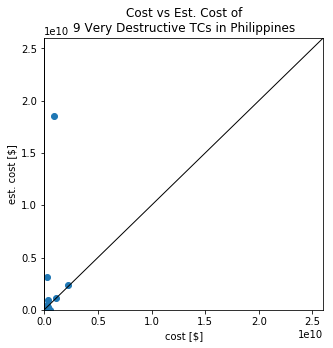

In [21]:
# Zoom out plot to include all points
plt.figure(figsize=(5, 5))
plt.scatter(cost_des,est_cost)
plt.xlabel('cost [$]')
plt.ylabel('est. cost [$]')
plt.plot([-1e10,3e10],[-1e10,3e10],color='k',linewidth=1)
plt.xlim([0,2.6e10])
plt.ylim([0,2.6e10])
plt.hlines(0,-0.5e20,2.5e20,linewidth=1)
plt.vlines(0,-0.5e20,2.5e20,linewidth=1)
plt.title('Cost vs Est. Cost of\n9 Very Destructive TCs in Philippines')

Text(0.5, 1.0, 'Cost vs Est. Cost of\n9 Very Destructive TCs in Philippines')

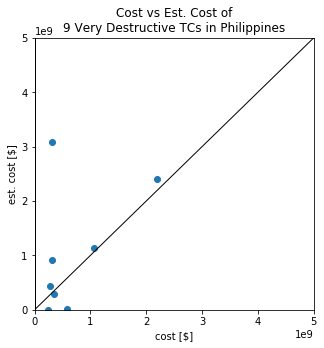

In [22]:
# Zoom in plot
plt.figure(figsize=(5, 5))
plt.scatter(cost_des,est_cost)
plt.xlabel('cost [$]')
plt.ylabel('est. cost [$]')
plt.plot([-1e10,3e10],[-1e10,3e10],color='k',linewidth=1)
plt.xlim([0,5e9])
plt.ylim([0,5e9])
plt.hlines(0,-0.5e20,2.5e20,linewidth=1)
plt.vlines(0,-0.5e20,2.5e20,linewidth=1)
plt.title('Cost vs Est. Cost of\n9 Very Destructive TCs in Philippines')

In [25]:
cost_des

[2200000000.0,
 1060000000.0,
 885000000.0,
 581000000.0,
 356000000.0,
 313000000.0,
 304000000.0,
 278000000.0,
 233000000.0]

In [26]:
ds_asset_losses_des = xr.DataArray.to_dataset(asset_losses,name='asset_losses')
ds_asset_losses_des.to_netcdf('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_SWATHS/wspd_phi_assetlosses_regvulnerability_des.nc')

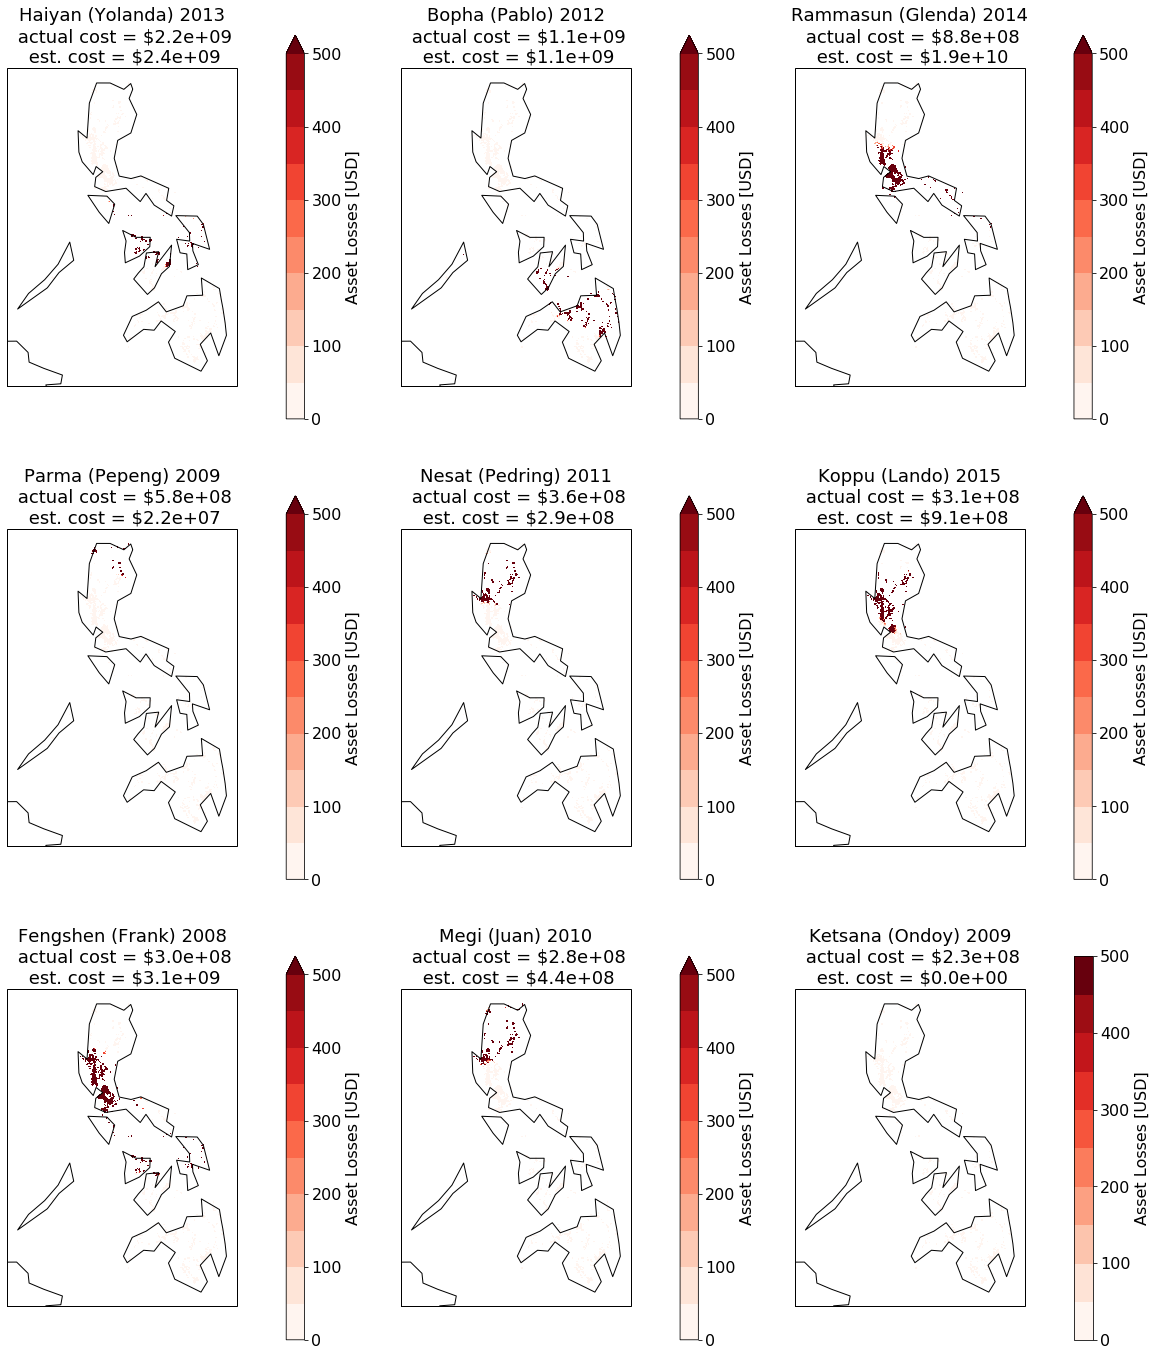

In [24]:
plt.figure(figsize=(20, 24))
for n in np.arange(len(name_des)):
    plt.subplot(3,3,n+1,projection=ccrs.PlateCarree())
    p = asset_losses[...,n].plot(levels=np.arange(0,550,50),transform=ccrs.PlateCarree(),cmap=plt.cm.Reds,add_colorbar=False)
    p.axes.coastlines()
    plt.title(name_des[n]+' '+str(dt_des[n].year)+'\n actual cost = $'+"{:.1e}".format(int(cost_des[n]),decimals=1)+'\n est. cost = $'+"{:.1e}".format(int(est_cost[n])),fontsize=18)
    cb = plt.colorbar(p, orientation="vertical", pad=0.15)
    cb.set_label(label='Asset Losses [USD]',fontsize=16)

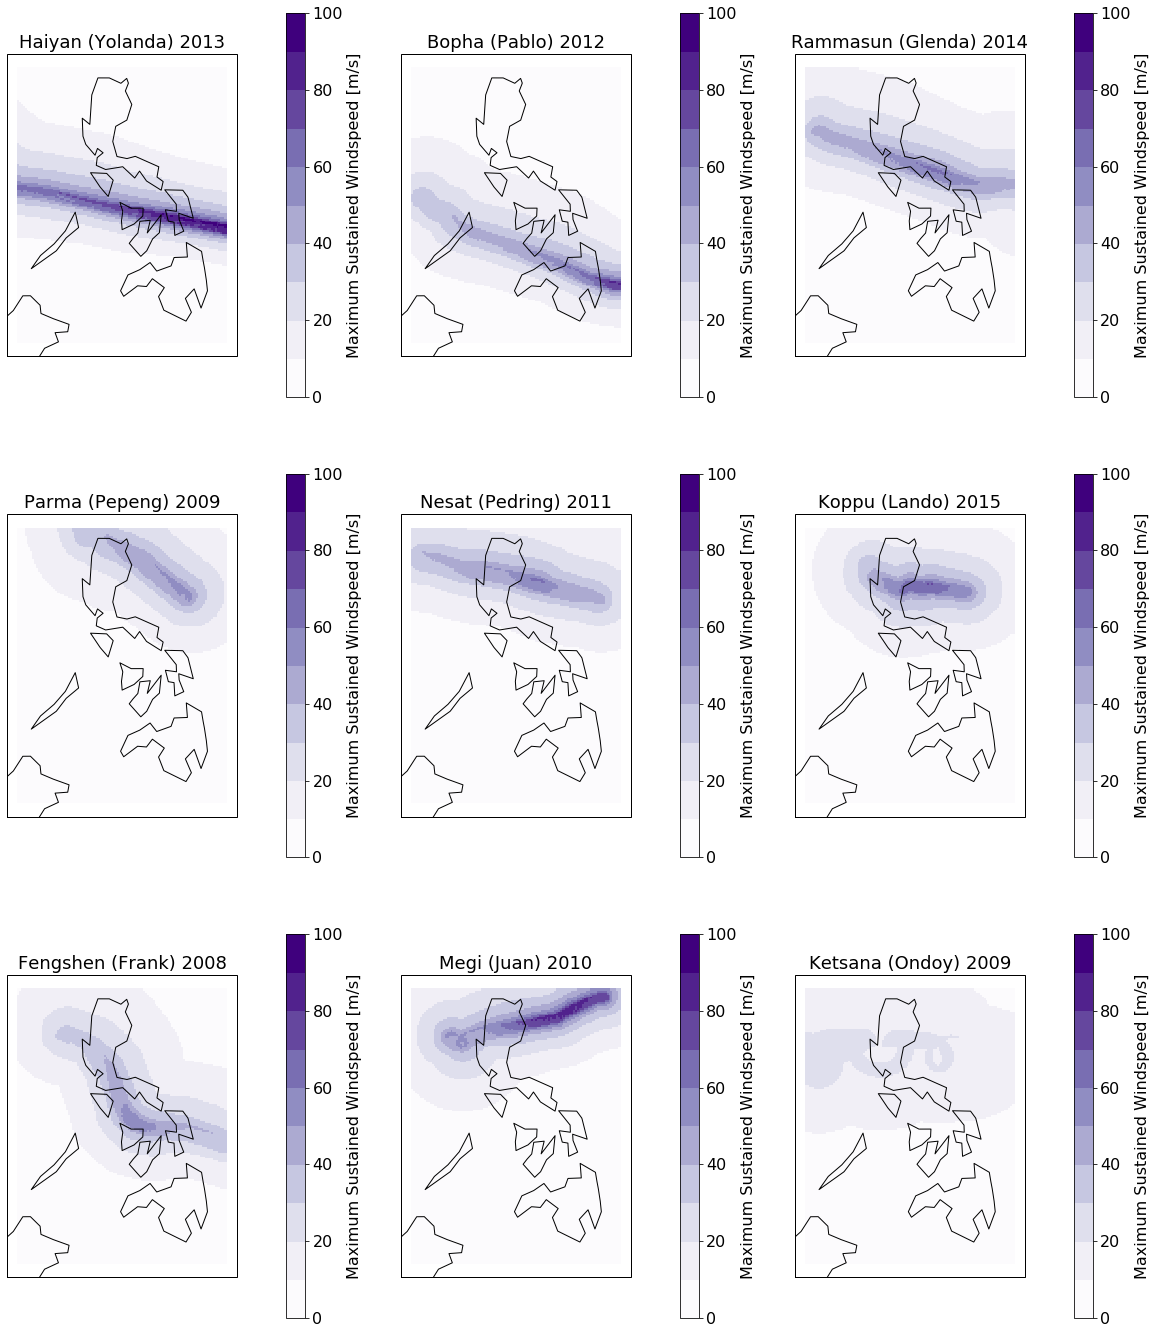

In [25]:
plt.figure(figsize=(20, 24))
for n in np.arange(len(name_des)):
    ax = plt.subplot(3,3,n+1,projection=ccrs.PlateCarree())
    p = swath_des[n].plot(transform=ccrs.PlateCarree(),cmap = plt.cm.Purples,levels=np.arange(0,110,10),add_colorbar=False)
    plt.title(name_des[n]+' '+str(dt_des[n].year),fontsize=18)
    ax.coastlines(color='k')
    cb = plt.colorbar(p, orientation="vertical", pad=0.15)
    cb.set_label(label='Maximum Sustained Windspeed [m/s]',fontsize=16)

In [ ]:
# Next Steps:
# Calculate losses for every storm I have, and save out in one netcdf file
# Calculate and plot losses for top 10 storms over Philippines, with total cost at top
# https://en.wikipedia.org/wiki/Typhoons_in_the_Philippines


# Calculate Asset Losses for Each Historical Storm

In [27]:
# Regrid wind swath
swath_out = regridder(swath)


In [28]:
# Calculate asset losses

Vthresh = 25.7# Eberenz et al 2020, value for Philippines; m/s
Vhalf = Vhalf_map.states.values#84.7# Eberenz et al 2020, value for Philippines using RMSF calculation; m/s
V = swath_out

f = vulnerability(V,Vthresh,Vhalf)

asset_losses = exposed_value*f


In [29]:
# Save out dataset of asset losses with dates
ds_asset_losses = xr.Dataset(
         {"asset_losses": (("lat", "lon", "nS"), asset_losses.values),
         "year": (("nS"), year),
         "month": (("nS"), month),
         "day": (("nS"), day)},
             coords={
            "nS":asset_losses.nS,
            "lat":asset_losses.lat,
            "lon":asset_losses.lon,
         },
         )

ds_asset_losses.to_netcdf('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_SWATHS/wspd_phi_assetlosses_regvulnerability.nc',mode='w')


# Calculate Philippines asset losses return periods

In [65]:
# Load data
ds_asset_losses = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_SWATHS/wspd_phi_assetlosses_regvulnerability.nc')
asset_losses = ds_asset_losses.asset_losses


In [66]:
asset_losses_reg = {}
for key in regions:
    mask0 = d_mask.states.where(d_mask.states==state_ids[key])
    mask = mask0/mask0
    asset_losses_reg[key] = (asset_losses*mask).sum(dim='lon',skipna = True).sum(dim='lat', skipna = True) # mask and calculate sum across region


In [67]:
# Save out data for asset_losses and period
for reg in regions:

    ds_asset_losses = xr.DataArray.to_dataset(asset_losses_reg[reg],name='asset_losses')

    ds_asset_losses.attrs["period_years"] = obsy

    ds_asset_losses.to_netcdf('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_REGION/assetlosses_'+regions_nospace[reg]+'.nc')

In [32]:
# Calculate total cost for storm over Philippines
est_cost = np.sum(np.sum(asset_losses,axis=0),axis=0)

# Calculate number of years observed
obsy = (ds_asset_losses.year[-1]-ds_asset_losses.year[0]).values


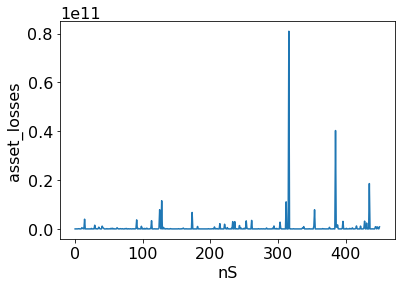

In [31]:
est_cost.plot()


Text(0, 0.5, 'Est. Cost Across Philippines [USD]')

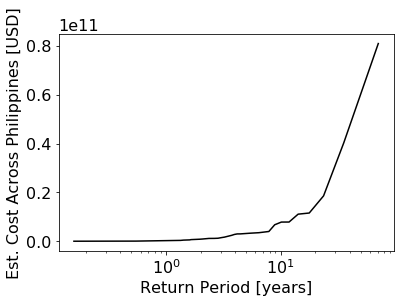

In [32]:
ax1 = plt.subplot(111)
obsw = est_cost
pdfevents,bins = np.histogram(obsw,np.unique(np.hstack([np.sort(obsw),obsw.max()+5]))) # determine frequency in each bin
cdfevents = 1.*np.cumsum(pdfevents[::-1])[::-1]/obsy # calculate cumulative frequency per year in each bin
returnP_o = 1./cdfevents # calculate return period (1/f)
dot, = ax1.semilogx(returnP_o[:],bins[:-1],'k-',label='obs',zorder=20)
plt.xlabel('Return Period [years]')
plt.ylabel('Est. Cost Across Philippines [USD]')


# Calculate number of storms reaching tropical storm strength in each region over period.

In [57]:
d_mask = d_mask.rename(longitude='lon',latitude='lat')

In [58]:
# Calculate max wind, and number of tropical storms, and their frequency, in each region
ts_count = {}
ts_per_year = {}
max_wind = {}
for key in regions:
    mask0 = d_mask.states.where(d_mask.states==state_ids[key])
    mask = mask0/mask0
    #mask = np.repeat(np.expand_dims(mask0,axis=0), np.shape(swath_out)[0], axis=0)
    max_wind[key] = (swath_out*mask).max(dim='lon',skipna = True).max(dim='lat', skipna = True)
    ts_count[key] = np.sum(max_wind[key]>(40/1.944))
    ts_per_year[key] = ts_count[key]/obsy

Text(0.5, 1.0, 'Eastern Visayas')

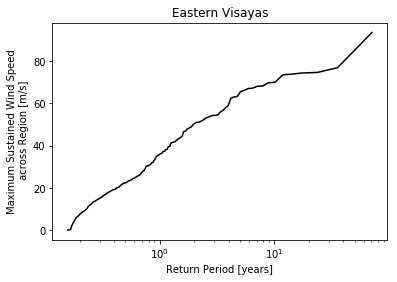

In [59]:
ax1 = plt.subplot(111)
obsw = max_wind['Eastern Visayas']
pdfevents,bins = np.histogram(obsw,np.unique(np.hstack([np.sort(obsw),obsw.max()+5]))) # determine frequency in each bin
cdfevents = 1.*np.cumsum(pdfevents[::-1])[::-1]/obsy # calculate cumulative frequency per year in each bin
returnP_o = 1./cdfevents # calculate return period (1/f)
dot, = ax1.semilogx(returnP_o[:],bins[:-1],'k-',label='obs',zorder=20)
plt.xlabel('Return Period [years]')
plt.ylabel('Maximum Sustained Wind Speed\n across Region [m/s]')
plt.title('Eastern Visayas')

In [61]:
regions

dict_keys(['ARMM', 'CAR', 'NCR', 'Ilocos Region', 'Cagayan Valley', 'Central Luzon', 'Calabarzon', 'Mimaropa', 'Zamboanga Peninsula', 'Bicol Region', 'Western Visayas', 'Central Visayas', 'Eastern Visayas', 'Northern Mindanao', 'Davao Region', 'Soccsksargen', 'Caraga'])

In [63]:
# Save out data for max wind and period

regions_nospace = {'ARMM':'ARMM', 'CAR':'CAR', 'NCR':'NCR', 'Ilocos Region':'IlocosRegion', 'Cagayan Valley':'CagayanValley',
                   'Central Luzon':'CentralLuzon', 'Calabarzon':'Calabarzon', 'Mimaropa':'Mimaropa', 'Zamboanga Peninsula':'ZamboangaPeninsula',
                   'Bicol Region':'BicolRegion', 'Western Visayas':'WesternVisayas', 'Central Visayas':'CentralVisayas', 
                   'Eastern Visayas':'EasternVisayas', 'Northern Mindanao':'NorthernMindanao', 'Davao Region':'DavaoRegion', 
                   'Soccsksargen':'Soccsksargen', 'Caraga':'Caraga'}

for reg in regions:

    direc_save = '/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_REGION/'

    ds_max_wind = xr.DataArray.to_dataset(max_wind[reg],name='max_wind')

    ds_max_wind.attrs["period_years"] = obsy

    ds_max_wind.to_netcdf(direc_save+'maxwind_'+regions_nospace[reg]+'.nc')

In [60]:
# Find exceedance values for different prescribed return periods
r = np.array([1.,5.,10.,20.,50.])
e_max_wind = r*0
for i in range(len(r)):
    index_of_returnperiod = np.argmin(np.abs(returnP_o-r[i]))
    e_max_wind[i] = bins[index_of_returnperiod]


In [35]:
# For synthetic storms, period should be set so frequency per year equals these values.
pickle.dump( ts_per_year, open( "ts_per_year.p", "wb" ) )
ts_per_year

{'ARMM': 0.0,
 'CAR': 2.408450704225352,
 'NCR': 1.732394366197183,
 'Ilocos Region': 2.732394366197183,
 'Cagayan Valley': 2.6901408450704225,
 'Central Luzon': 3.1267605633802815,
 'Calabarzon': 2.7183098591549295,
 'Mimaropa': 2.4788732394366195,
 'Zamboanga Peninsula': 0.18309859154929578,
 'Bicol Region': 2.8309859154929575,
 'Western Visayas': 1.4507042253521127,
 'Central Visayas': 1.4507042253521127,
 'Eastern Visayas': 2.2253521126760565,
 'Northern Mindanao': 0.4225352112676056,
 'Davao Region': 0.1267605633802817,
 'Soccsksargen': 0.04225352112676056,
 'Caraga': 1.0140845070422535}